## Deployed using Flask
<img src = 'BlogPosts/Screenshot 2020-01-11 at 1.26.15 PM.png'/>

## Deploying the Image Captioning Model

- We will write an Inference Code that loads the latest checkpoint and makes prediction on the given image.

- One important part is to load the model in memory for which we are using the tf.train.Checkpoint() method, which loads all of thhe learned weights for optimizer,encoder,decoder into the memory.

- Now, we will also create evaluate() method, which defines the prediction loop. To make sure that the prediction ends after certain words, we will stop providing when the model predicts the < end > token.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ls

drive/  image_captnng.py  __pycache__/  sample_data/


In [4]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [5]:
from image_captioning import *
from pickle import load

Using TensorFlow backend.


## Evaluating the Captioning Model: 
- The evaluate function is similar to the training loop, except we don't use Teacher Forcing here. The input to Decoder at each time step is its previous predictions, along with the hidden state and the ENCODER output.
- Few key points to remember while making predictions.
    1. Stop predicting when the model predicts the end token.
    2. Store the attention weights for every time step.

In [ ]:
def evaluate(image):
        attention_plot = np.zeros((max_length, attention_features_shape))

        hidden = decoder.reset_state(batch_size=1)

        temp_input = tf.expand_dims(load_image(image)[0], 0)
        img_tensor_val = image_features_extract_model(temp_input)
        img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

        features = encoder(img_tensor_val)

        dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
        result = []

        for i in range(max_length):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

            predicted_id = tf.argmax(predictions[0]).numpy()
            result.append(tokenizer.index_word[predicted_id])

            if tokenizer.index_word[predicted_id] == '<end>':
                return result, attention_plot

            dec_input = tf.expand_dims([predicted_id], 0)

        attention_plot = attention_plot[:len(result), :]
        return result, attention_plot

In [ ]:
def predict(Image_path):
    
    checkpoint_path = "./drive/My Drive/checkpoint_finally6/train/ckpt-4"
    train_captions = load(open('./drive/My Drive/captions.pkl', 'rb'))


    # Choose the top 5000 words from the vocabulary
    top_k = 5000   
    train_seqs , tokenizer = tokenize_caption(top_k ,train_captions)

    #restoring the model
    
    ckpt = tf.train.Checkpoint(encoder=encoder,decoder=decoder,optimizer = optimizer)
    ckpt.restore(checkpoint_path)

    new_img =  Image_path
    #image_extension = Image_path[-3:]

    #image_path = tf.keras.utils.get_file('image'+image_extension,origin=Image_path)

    result, attention_plot = evaluate(new_img)
    for i in result:
        if i=="<unk>":
            result.remove(i)
        else:
            pass
    
    print('Prediction Caption: ', ' '.join(result).rsplit(' ', 1)[0])

    plot_attention(new_img, result, attention_plot)
    
    image_plot(new_img)
    
    

131072/129838 [==============================] - 0s 0us/step
Prediction Caption:  brown dog is standing in grassy field
jpg


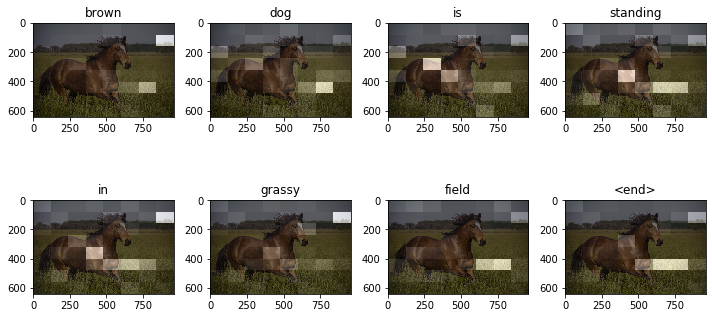

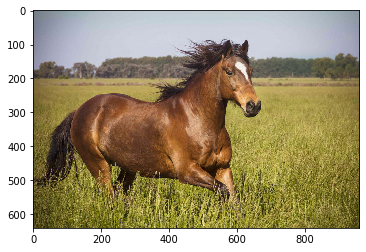

In [5]:
predict('https://www.thesprucepets.com/thmb/wd4VS5A5UCHLF0IBG-DsVfrLypk=/960x0/filters:no_upscale():max_bytes(150000):strip_icc()/horse-galloping-in-grass-688899769-587673275f9b584db3a44cdf.jpg')

Prediction Caption:  white dog is running through leaves


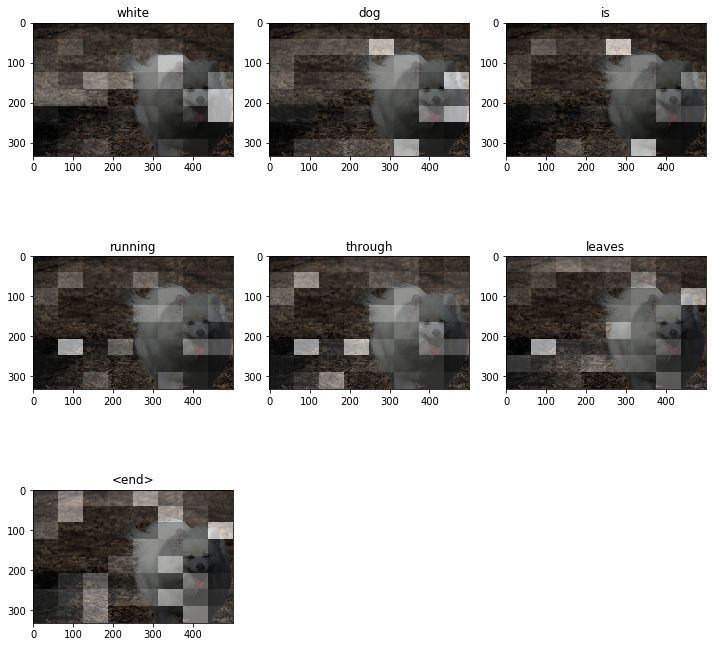

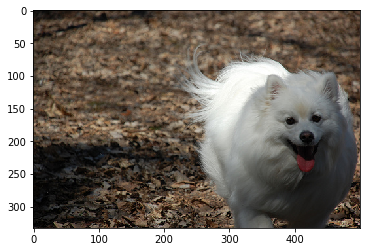

In [23]:
predict('./drive/My Drive/Flicker8k_Dataset/3439243433_d5f3508612.jpg')

Prediction Caption:  man mountain climbing up snow covered mountain


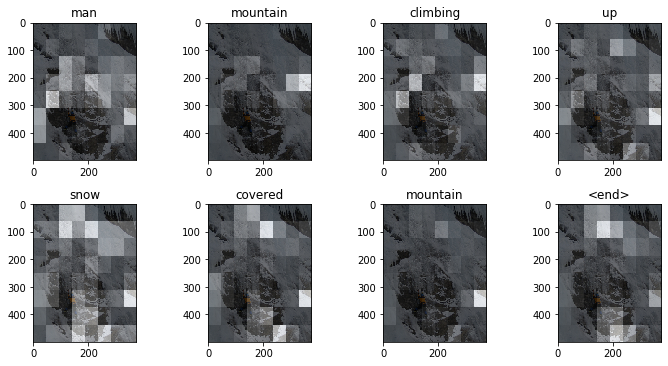

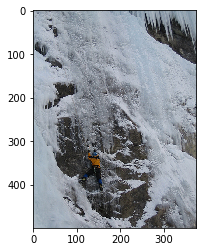

In [9]:
predict('./drive/My Drive/Flicker8k_Dataset/97577988_65e2eae14a.jpg')

Prediction Caption:  two people in rocky scenery


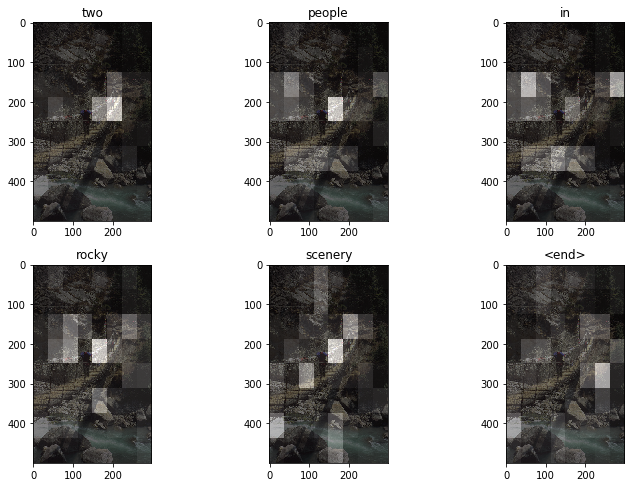

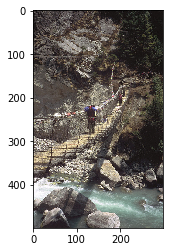

In [11]:
predict('./drive/My Drive/Flicker8k_Dataset/96978713_775d66a18d.jpg')